# Direct multi-step forecaster

`ForecasterAutoreg` and `ForecasterAutoregCustom` models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each step that has to be predicted. This strategy, commonly known as direct multistep forecasting, is computationally more expensive than the recursive since it requires training several models. However, in some scenarios, it achieves better results. This type of model can be obtained with the `ForecasterAutoregDirect` class and can also include one or multiple exogenous variables.

<p align="center"><img src="../img/diagram-direct-multi-step-forecasting.png" style="width: 700px"></p>

To train a `ForecasterAutoregDirect` a different training matrix is created for each model.

## Libraries

In [9]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

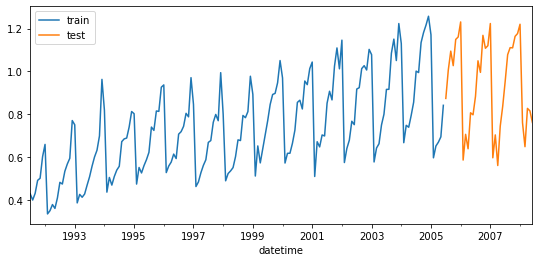

In [10]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [11]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-03-11 23:45:07 
Last fit date: 2022-03-11 23:45:07 
Skforecast version: 0.4.3 

## Prediction

In [12]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(3)

2005-07-01    0.952051
2005-08-01    1.004145
2005-09-01    1.114590
Freq: MS, Name: pred, dtype: float64

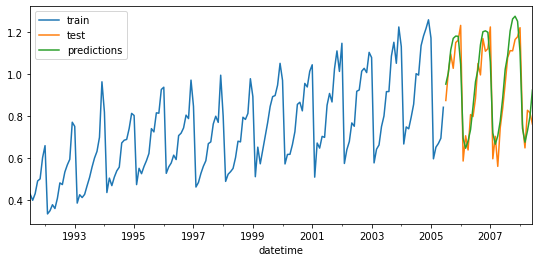

In [13]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [14]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008419597278831951


## Feature importance

Since `ForecasterAutoregDirect` fits one model per step, it is necessary to specify from which model retrieves its feature importance.

In [15]:
forecaster.get_feature_importance(step=1)

,feature,importance
0,lag_1,0.139299
1,lag_2,0.051089
2,lag_3,0.044192
3,lag_4,-0.019868
4,lag_5,-0.017935
5,lag_6,-0.013233
6,lag_7,-0.021063
7,lag_8,-0.012591
8,lag_9,0.011918
9,lag_10,0.020511


## Extract training matrix

Two steps are needed. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [16]:
X, y = forecaster.create_train_X_y(data_train)
# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
                step    = 1,
                X_train = X,
                y_train = y,
           )

X_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1995-09-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795
1995-10-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906
1995-11-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159
1995-12-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543


In [17]:
y_1.head(4)

datetime
1995-09-01    0.595223
1995-10-01    0.771258
1995-11-01    0.751503
1995-12-01    0.387554
Freq: MS, Name: y_step_1, dtype: float64

In [18]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>